In [2]:
# Insert your project token

# Classifying customer notes with Watson NLP

This notebook was created using the [sample notebooks](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/636001e59902133a4a23fd89f010e4cb?context=wx) in the Gallery 

We will train 2 models:
1. SVM
2. Ensemble


Begin by importing and initializing some helper libs that are used throughout the notebook.

In [3]:
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

import json
import seaborn as sn
import matplotlib.pyplot as plt

In [4]:
import watson_nlp

from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.toolkit import fileio
from watson_nlp.blocks.classification.svm import SVM

<a id="loadData"></a>
## Load customer interaction notes

**Important: regenerate data access code for the file in your project. Make sure to change the dataframe name after generation to** *complaint_df*

In [5]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='A1FXJPFfY-kKaIxcVqMcaxTJcEHewBasP',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'llmworkshopyi-donotdelete-pr-zvg5eylmuyhhek'
object_key = 'classification_training.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
complaint_df = pd.read_csv(body)
complaint_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/18/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Was not notified of investigation status or results,"On XX/XX/2020, I sent a letter regarding inaccurate and unknown things on my credit report. To this day over 60 days later I have not received a response yet. I feel like Im being taken advantage of and being ignored for my disputes and concerns. \nSection 611 ( A ) it is plainly stated that a failure to investigate these items within 30 days gives a reason to immediately remove those items fr...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TN,38115,None,Consent provided,Web,03/18/21,Closed with explanation,Yes,NaN,4225171
1,03/22/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,"This company violated the law Pursuant to 15 USC 1681a ( 2 ) ( B ) any authorization or approval of a specific extension of credit directly or indirectly by the issuer of the credit card or similar credit device Should be excluded from a consumer report. The definition of a credit card under 15 USC 1681 is the same as it is under 15 USC 1602 ( l ) which is the term credit card means any card, ...",None,AMERICAN EXPRESS COMPANY,NY,10457,None,Consent provided,Web,03/22/21,Closed with explanation,Yes,NaN,4233511
2,03/15/21,Mortgage,VA mortgage,Trouble during payment process,None,"For XX/XX/2019, I eliminated the direct payment and began to make the payments at the institution. They the Firstbank of Puerto Rico made the mistake of not recording the payments made using this method and this mistake is affecting my credit score. I have never failed to make a mortgage payment. The time it took them to fix the problem, they send to the credit companies as a delay of 30 days,...",None,FIRSTBANK PUERTO RICO,PR,00662,Servicemember,Consent provided,Web,03/15/21,Closed with explanation,Yes,NaN,4213468
3,03/29/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Account information incorrect,"I recently mailed you a letter disputing items appearing on my credit report, which you maintain. Your response to my letter was to deem my letter "" suspicious '', implying it was not written by me and furthermore in a threatening to report my letter to law enforcement and/or state and federal regulatory agencies. Your response is ludicrous. \nAbsolutely nothing in my letter could reasonably g...",None,"EQUIFAX, INC.",IL,60610,None,Consent provided,Web,03/29/21,Closed with explanation,Yes,NaN,4255463
4,03/29/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Was not notified of investigation status or results,"I hope you can help me to remove these items from my credit because I can not progress in my life like buy a house, get car or even get a credit card. The way life is now credit is everything. On XX/XX/21, I sent a letter regarding inaccurate and unknown things on my credit report. To this day, I have not received a response yet. I feel like I'm being taken advantage of and being ignored of my...",None,"EQUIFAX, INC.",SC,29505,None,Consent provided,Web,03/29/21,Closed with explanation,Yes,NaN,4255255


In [6]:
text_col = 'Consumer complaint narrative'

complaint_df.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/18/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Was not notified of investigation status or results,"On XX/XX/2020, I sent a letter regarding inaccurate and unknown things on my credit report. To this day over 60 days later I have not received a response yet. I feel like Im being taken advantage of and being ignored for my disputes and concerns. \nSection 611 ( A ) it is plainly stated that a failure to investigate these items within 30 days gives a reason to immediately remove those items fr...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TN,38115,None,Consent provided,Web,03/18/21,Closed with explanation,Yes,NaN,4225171
1,03/22/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,"This company violated the law Pursuant to 15 USC 1681a ( 2 ) ( B ) any authorization or approval of a specific extension of credit directly or indirectly by the issuer of the credit card or similar credit device Should be excluded from a consumer report. The definition of a credit card under 15 USC 1681 is the same as it is under 15 USC 1602 ( l ) which is the term credit card means any card, ...",None,AMERICAN EXPRESS COMPANY,NY,10457,None,Consent provided,Web,03/22/21,Closed with explanation,Yes,NaN,4233511


Let's look at all product groups that are available in the data set because these are the classes that the classifier should predict from a given complaint text.

In [7]:
product_counts = complaint_df['Product'].value_counts()
product_counts

Credit reporting, credit repair services, or other personal consumer reports    8890
Debt collection                                                                 3340
Credit card or prepaid card                                                     1555
Mortgage                                                                        1548
Checking or savings account                                                     1122
Money transfer, virtual currency, or money service                               914
Vehicle loan or lease                                                            373
Student loan                                                                     193
Payday loan, title loan, or personal loan                                        193
Name: Product, dtype: int64

<a id="prepareData"></a>
## Prepare training and test data

Many classification algorithms work best if the training samples are equally split across the classes. If the data is unbalanced, algorithms might decide to favor classes with many samples to achieve an overall good result. To avoid this, you will sample the data in the next step to have a similar amount of samples for each class.

To avoid long runtimes in this sample notebook, you will use only a small number of samples. However, this can reduce the quality of the classification models. In a real-case scenario, you should increase the number of samples per product group to get better results.

In [8]:
# number of complaints for the each product group
sample_size = 300

train_test_df = complaint_df.query("Product != 'Student loan' and Product != 'Payday loan, title loan, or personal loan'")

# sample the data to have the same number of complaints for each product group
train_test_df = train_test_df.groupby('Product').sample(n=sample_size, random_state=5).reset_index(drop=True)

In the next step, you will split the data into training and test data (ratio:80/20).

In [9]:
# 80% training data
train_orig_df = train_test_df.groupby('Product').sample(frac=0.8, random_state=6)
print("Training data:")
print("Number of training samples: {}".format(len(train_orig_df)))
print("Samples by product group:\n{}".format(train_orig_df['Product'].value_counts()))

# 20% test data
test_orig_df = train_test_df.drop(train_orig_df.index)
print("\nTest data:")
print("Number of test samples: {}".format(len(test_orig_df)))
print("Samples by product group:\n{}".format(test_orig_df['Product'].value_counts()))

# re-index after sampling
train_orig_df = train_orig_df.reset_index(drop=True)
test_orig_df = test_orig_df.reset_index(drop=True)

Training data:
Number of training samples: 1680
Samples by product group:
Checking or savings account                                                     240
Credit card or prepaid card                                                     240
Credit reporting, credit repair services, or other personal consumer reports    240
Debt collection                                                                 240
Money transfer, virtual currency, or money service                              240
Mortgage                                                                        240
Vehicle loan or lease                                                           240
Name: Product, dtype: int64

Test data:
Number of test samples: 420
Samples by product group:
Checking or savings account                                                     60
Credit card or prepaid card                                                     60
Credit reporting, credit repair services, or other personal consumer reports  

You have created two dataframes, one for the training and one for the test data. The data is still in its original format. Now you need to bring the data into a format that is usable by the Watson NLP classification algorithms. This can be either *JSON* or *CSV* format. 

In the sample, you will create the data in *JSON* format. The training and test data is written to files.

In [10]:
def prepare_data(df):
    # only the text column and the target label *Product* are needed
    df_out = df[[text_col, 'Product']].reset_index(drop=True)
    # rename to the identifiers expected by Watson NLP
    df_out = df_out.rename(columns={text_col: "text", 'Product': 'labels'})
    # the label column should be an array (although we have only one label per complaint)
    df_out['labels'] = df_out['labels'].map(lambda label: [label,])
    return df_out
    
train_df = prepare_data(train_orig_df)
train_file = './train_data.json'
train_df.to_json(train_file, orient='records')
    
test_df = prepare_data(test_orig_df)
test_file = './test_data.json'
test_df.to_json(test_file, orient='records')

train_df.head(2)

,text,labels
0,"A {$400.00} signup bonus not paid as advertised when newly opening Citibank Account Package. \nUnder the Promotion XXXX I opened the Citi checking and savings package on XX/XX/XXXX, fulfilled the requirement of depositing the minimum balance of {$15000.00} using Non-Citibank-funds on XX/XX/XXXX, kept the balance until XX/XX/XXXX, and waited until XX/XX/XXXX. Until now, no signup bonus was cred...",[Checking or savings account]
1,On XX/XX/2021 I deposited my paycheck into my XXXX banking account when I signed up I signed up for brokerage Plus mobile checking my brokerage account is open but I can not get a checking account to open up there for all of my money is stuck in my brokerage account now and I am unable to withdraw my money I tried getting a hold of XXXX to get this problem fixed they tell me that I need my ide...,[Checking or savings account]


<a id="svm"></a>
## Train a SVM classification model with Watson NLP

SVM is an establishd classification approach. Watson NLP includes an SVM algorithm that exploits the `SnapML` libraries for faster training. The algorithm utilizes USE embeddings that encode word-level semantics into a vector space.

The SVM classifier block depends on the syntax block. So, start by loading the syntax model and the USE embeddings.

In [11]:
# Syntax Model
syntax_model = watson_nlp.load('syntax_izumo_en_stock')
# USE Embedding Model
use_model = watson_nlp.load('embedding_use_en_stock')

Classification blocks expect the training data in data streams. You can create data streams using several utility methods, as shown below.

In [12]:
training_data_file = train_file

# Create datastream from training data
data_stream_resolver = DataStreamResolver(target_stream_type=list, expected_keys={'text': str, 'labels': list})
training_data = data_stream_resolver.as_data_stream(training_data_file)

# Create Syntax stream
text_stream, labels_stream = training_data[0], training_data[1]
syntax_stream = syntax_model.stream(text_stream)

use_train_stream = use_model.stream(syntax_stream, doc_embed_style='raw_text')
use_svm_train_stream = watson_nlp.data_model.DataStream.zip(use_train_stream, labels_stream)

Train the classifier. **Note:** This cell will run for several minutes.

In [13]:
# Train the SVM model
svm_model = SVM.train(use_svm_train_stream)

Before you evalute the model, you will train another one and look at how to store and reload models from the project.

<a id="ensemble"></a>
## Train an ensemble classification model with Watson NLP

The ensemble model may combine three classification models: 

- SVM with TF-IDF features
- SVM with USE (Universal Sentence Encoder) features 
- CNN 

You will use SVM with TF-IDF and SVM with USE as algorithms for the Ensemble classifier.
It computes the weighted mean of classification predictions using confidence scores. You will use the default weights which can be fine-tuned in subsequent steps.

The ensemble workflow is very easy to use and the model performance can be a lot better than individual algorithms.

It depends on the syntax model and the USE embeddings. They are passed with the file containing the training data.

Train the ensemble classifier.

In [14]:
from watson_nlp.workflows.classification import GenericEnsemble
from watson_nlp.workflows.classification.base_classifier import TFidfSvm
from watson_nlp.workflows.classification.base_classifier import UseSvm

ensemble_model = GenericEnsemble.train(training_data, syntax_model, 
                                       base_classifiers_params=[
                                           TFidfSvm.TrainParams(syntax_model=syntax_model),
                                           UseSvm.TrainParams(syntax_model=syntax_model, use_embedding_model=use_model, doc_embed_style='raw_text')])

<a id="storeLoad"></a>
## Store and load classification models (optional)

You can save a model as a project asset. `model.as_bytes()` creates a ZIP archive, which is provided as a *BytesIO* object that is stored in the project.

**Note:** These steps are **optional**. You can skip them, and continue at [Classify test data and compare model quality](#scoring)

Save both models in your project.

In [16]:
wslib.save_data('classify_notes_svm', data=svm_model.as_bytes(), overwrite=True)

{'name': 'classify_notes_svm',
 'asset_type': 'data_asset',
 'asset_id': 'cac29622-b742-4b89-b1f4-4d89e01b0072',
 'attachment_id': '4624adc8-d034-405f-91ff-1a562f0a72ba',
 'filepath': 'classify_notes_svm.',
 'data_size': None,
 'mime': 'application/binary',
 'summary': ['created or overwritten file',
  'created data asset',
  'created attachment']}

In [17]:
wslib.save_data('classify_notes_ensemble', data=ensemble_model.as_bytes(), overwrite=True)

{'name': 'classify_notes_ensemble',
 'asset_type': 'data_asset',
 'asset_id': '582b3c90-2afe-4762-aaeb-9211e8ac350f',
 'attachment_id': 'c321beb0-ca0f-4831-89fc-014837757d3b',
 'filepath': 'classify_notes_ensemble.',
 'data_size': None,
 'mime': 'application/binary',
 'summary': ['created or overwritten file',
  'created data asset',
  'created attachment']}

The ZIP archive created by the `save_data` function is compatible to the `watson_nlp.load()` function that is also used to load the predefined Watson NLP models.

<a id="scoring"></a>
## Classify test data and compare model quality

Now you are able to run the trained models on new data. You will run the models on the test data so that the results can also be used for model evaluation. For illustration purposes, the data is used in the original format that you started out with because the format of the new complaints that you receive might also be in that format.

Notice that the SVM with USE embeddings model requires you to run the syntax model on the input texts first.

Create a helper method to run both models on a single complaint and return the predicted product groups of both models.

In [19]:
# Load the models we previously saved in the project for testing

svm_model = watson_nlp.load(wslib.load_data('classify_notes_svm'))
ensemble_model = watson_nlp.load(wslib.load_data('classify_notes_ensemble'))

In [20]:
def predict_product(text):
    # run syntax model first
    syntax_result = syntax_model.run(text)
    # run SVM model on top of syntax result
    svm_preds = svm_model.run(use_model.run(syntax_result, doc_embed_style='raw_text'))
    
    predicted_svm = svm_preds.to_dict()["classes"][0]["class_name"]
    
    ensemble_preds = ensemble_model.run(text)
    predicted_ensemble = ensemble_preds.to_dict()["classes"][0]["class_name"]
    return (predicted_svm, predicted_ensemble)

Run the models on the complete test data.

In [21]:
predictions = test_orig_df[text_col].apply(lambda text: predict_product(text))
predictions_df = pd.DataFrame.from_records(predictions, columns=('Predicted SVM', 'Predicted Ensemble'))
   
result_df = test_orig_df[[text_col, "Product"]].merge(predictions_df, how='left', left_index=True, right_index=True)
result_df.head()

,Consumer complaint narrative,Product,Predicted SVM,Predicted Ensemble
0,"Bank of America has been abusive in a hold on funds of {$3500.00}. from XXXXXXXX XXXX Draft from Business Checking ending in {$6300.00}, which were swiftly collected from XXXX after Bank of America ATM deposit on XX/XX/XXXX. \n\nThe funds did not credit to the Bank of America Personal Checking account ending in XXXX, for XXXX XXXX XXXX, XXXX XXXX XXXX, CA XXXX. The Branch has contended that th...",Checking or savings account,Checking or savings account,Checking or savings account
1,"Navy Federal has made it impossible to access my money but VERY easy to deposit. I had direct deposit with Navy Fed where I also have stimulus checks deposited. They locked me out of accessing my acct online and only can access by calling or going in person. However because in Texas it has been impossible to renew drivers licenses because of XXXX, I have not been able to access in person eithe...",Checking or savings account,Checking or savings account,Checking or savings account
2,My account was closed on XX/XX/21 for what they said was a suspicious XXXX payment credited to my account. I have been on the phone everyday with them since for hours trying to get this all sorted out and chatting in. They say i wont get my money until may and they wont give me any funds. This is absolutely ridiculous. How am i supposed to live without my money? This is criminal. I need my fun...,Checking or savings account,"Money transfer, virtual currency, or money service","Money transfer, virtual currency, or money service"
3,"Citi Bank for the past year has charged my checking/Savings accounts a monthly fee when all accounts had a combined total that was higher than what Citi Bank stated for "" FeeFree ''. Citi Bank did not return the money that they illegally took from my accounts.",Checking or savings account,Checking or savings account,Checking or savings account
4,"XXXX identity theft and fraudulent charges! \n\nIn XXXX of 2021, XXXX charged my debit card for 60 transactions totaling {$9900.00}. As this is a business account for XXXX XXXX XXXX and I am the XXXX, I identified the problem at month end reconciliation and immediately reported it to Bank of America. The criminal also used my debit card to charge {$1200.00} in auto loan and Bill Pay expenses...",Checking or savings account,Checking or savings account,Checking or savings account


### Out-of-the-box model evaluation using Watson NLP

Watson NLP offers a method to calculate different quality metrics for a given model. Use the test data to evaluate the quality of your models.

In [22]:
# run the models on the test data - this time in batch mode
preprocess_func = lambda raw_doc: use_model.run_batch(syntax_model.run_batch(raw_doc))
svm_model.evaluate_quality(test_file, preprocess_func=preprocess_func)

{'per_class_confusion_matrix': {'Checking or savings account': {'true_positive': 25,
   'false_positive': 168,
   'false_negative': 35,
   'precision': 0.12953367875647667,
   'recall': 0.4166666666666667,
   'f1': 0.1976284584980237},
  'Money transfer, virtual currency, or money service': {'true_positive': 1,
   'false_positive': 33,
   'false_negative': 59,
   'precision': 0.029411764705882353,
   'recall': 0.016666666666666666,
   'f1': 0.02127659574468085},
  'Debt collection': {'true_positive': 10,
   'false_positive': 53,
   'false_negative': 50,
   'precision': 0.15873015873015872,
   'recall': 0.16666666666666666,
   'f1': 0.1626016260162602},
  'Credit card or prepaid card': {'true_positive': 7,
   'false_positive': 52,
   'false_negative': 53,
   'precision': 0.11864406779661017,
   'recall': 0.11666666666666667,
   'f1': 0.11764705882352941},
  'Vehicle loan or lease': {'true_positive': 8,
   'false_positive': 22,
   'false_negative': 52,
   'precision': 0.26666666666666666

You can see that the precision, recall and f1-measure for some classes is much lower than for others. The reason might be that it is difficult to differentiate between some classes. 

To find out if this is true, create a custom confusion matrix to see if there are classes that seem to be very close and might have been classified inappropriately.

### Creating and plotting a confusion matrix

Use the pandas *crosstab* to create a confusion matrix for both the SVM and the ensemble model and plot them as *Seaborn* heatmaps.

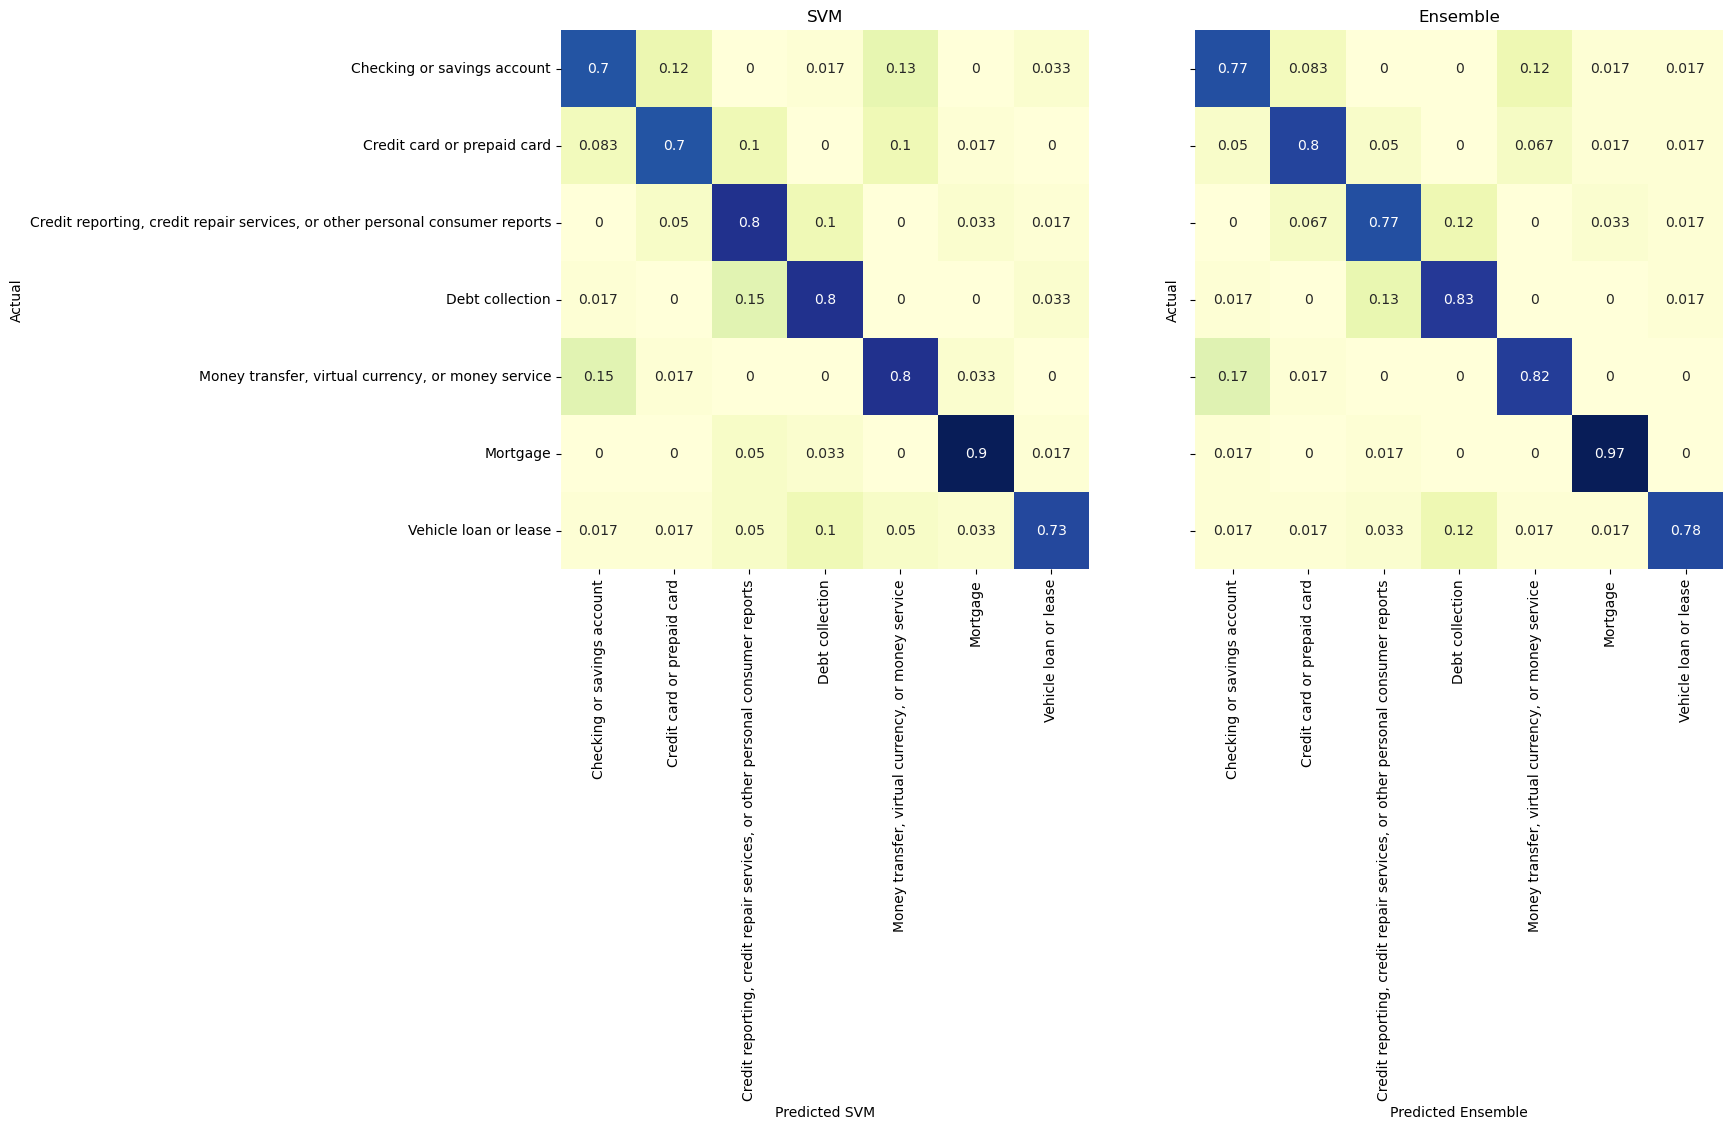

In [23]:
SVM_confusion_df = pd.crosstab(result_df['Product'], result_df['Predicted SVM'], rownames=['Actual'], normalize='index')
ensemble_confusion_df = pd.crosstab(result_df['Product'], result_df['Predicted Ensemble'], rownames=['Actual'], normalize='index')

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))

sn.heatmap(SVM_confusion_df, annot=True, cmap="YlGnBu", ax=ax1, cbar=False)
sn.heatmap(ensemble_confusion_df, annot=True, cmap="YlGnBu", ax=ax2, cbar=False)
ax1.title.set_text("SVM")
ax2.title.set_text("Ensemble")
ax2.set_yticklabels([])

plt.show()

#### Findings

In the confusion matrix for the SVM model you can now see that complaints for `Credit reporting, credit repair services, or other personal consumer reports` are often misclassified as `Debt collection` - and vice versa. Other common misclassifications can be gathered from the table.

Overall, the ensemble model performs better than the SVM model. 

In subsequent steps, consider increasing the size of the training data or adjusting the weights of the ensemble model to gain better results.

<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can train and run different text classifiers using Watson NLP.

### Authors
*Simone Zerfass IBM, Germany and Alexander Lang IBM, Germany*
*Updated for the workshop by Elena lowery


# <hr>
Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.